


# <span style="color:rgb(213,80,0)">Comparación del código de control de robots seriales</span>

***ALUMNO: ROMEO HERNANDEZ VILLA***

***CARRERA: INGENIERIA MECATRONICA***

***MATERIA: ROBOTICA***

***GRUPO: 01***

***PROFESOR: M.I. Erik Peña Medina***

# Documentación de Nodos de ROS 2: Control de Robots

En este notebook vamos a documentar dos nodos de ROS 2 hechos en Python. El objetivo es entender qué hace cada uno, por qué lo hace y cómo se relaciona con los conceptos de robótica que hemos visto, como la cinemática, las trayectorias y las máquinas de estado.

Vamos a analizar:
1.  **`scara_tray_line_py.py`**: Un nodo para generar una **trayectoria en línea recta** para un robot SCARA.
2.  **`dofbot_sequence_py.py`**: Un nodo que ejecuta una **secuencia de pasos** (una "máquina de estados") para una tarea de *pick and place* con el Dofbot.

## Archivo 1: `scara_tray_line_py.py`

### 1. Resumen General

Este nodo controla un robot tipo SCARA (o un robot planar RRR de 3 grados de libertad). Su objetivo principal es mover el efector final (la "mano" del robot) **describiendo una línea recta perfecta** en el plano XY, mientras también cambia su orientación de forma suave.

Para lograr esto, el programa:
1.  Define una **posición inicial** (`x_1`, `y_1`, `theta_1`) y una **posición final** (`x_2`, `y_2`, `theta_2`).
2.  Usa un "timer" para calcular, paso a paso, puntos intermedios en esa línea recta. A esto se le llama **interpolación lineal**.
3.  En cada paso, calcula la **cinemática inversa** para encontrar qué ángulos (`theta_1`, `theta_2`, `theta_3`) necesitan tener las articulaciones para que la "mano" esté en ese punto exacto de la línea.
4.  Publica estos ángulos como un mensaje `JointTrajectory` en el tópico `/scara_trajectory_controller/joint_trajectory`. El controlador del robot (en Gazebo o real) recibe esto y se mueve.

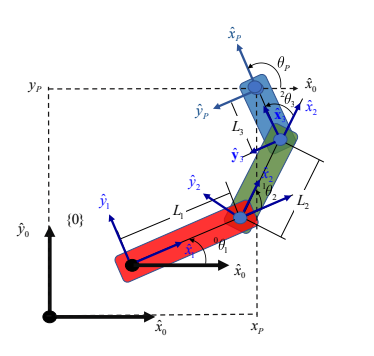


Figura 1. Diagrama 2D general de robot RRR SCARA


### 2. Análisis del Código (Celda por Celda)

#### Celda 1: Importaciones

Primero, importamos todas las librerías necesarias.

In [ ]:
#!/usr/bin/env python3

import rclpy
from rclpy.node import Node
from trajectory_msgs.msg import JointTrajectory, JointTrajectoryPoint
from builtin_interfaces.msg import Duration

import time
from math import cos, sin, acos, asin, atan2, sqrt

**Explicación de las Importaciones:**
* `rclpy` y `rclpy.node.Node`: Son la base de ROS 2 en Python. Nos permiten crear un "Nodo" (nuestro programa).
* `JointTrajectory`, `JointTrajectoryPoint`: ¡Estos son los **mensajes clave**! No le decimos al robot "muévete a 10º" y ya. Le enviamos un plan completo, una **Trayectoria**.
    * `JointTrajectory`: Es el mensaje "contenedor". Dice "esta trayectoria es para estas articulaciones..." y contiene una lista de puntos.
    * `JointTrajectoryPoint`: Es cada "parada" o "punto de control" en la trayectoria. Define una postura (`positions`) y el tiempo para llegar a ella (`time_from_start`).
* `Duration`: Un tipo de mensaje para especificar el tiempo (segundos y nanosegundos).
* `math`: Importamos funciones matemáticas (coseno, arcocoseno, `atan2`, etc.) que son **fundamentales** para calcular la cinemática inversa.

#### Celda 2: La Clase del Nodo `ScaraTrayLineNode`

Aquí definimos el "cerebro" de nuestro nodo. Creamos una clase que hereda de `Node`.

In [ ]:
class ScaraTrayLineNode(Node):
    def __init__(self):
        super().__init__("scara_tray_line_node")
        topic_name = "/scara_trajectory_controller/joint_trajectory"
        self.joints_ = ['link_1_joint', 'link_2_joint', 'link_3_joint']
        self.lamda_ = 0
        self.Tiempo_ejec_ = 10  # Pasos totales o tiempo total de la trayectoria

        # Creamos el publicador
        self.scara_tray_pub_ = self.create_publisher(
            JointTrajectory, topic_name, 10)
        
        # Creamos el timer que ejecutará la lógica
        self.tray_timer_ = self.create_timer(
            1, self.trayectory_cbck)  # Se ejecuta cada 1 segundo
        
        self.get_logger().info(
            'Scara activo, trayectoria linea recta')

    def trayectory_cbck(self):
        # 1. Preparamos los mensajes
        trayectory_msg = JointTrajectory()
        trayectory_msg.joint_names = self.joints_
        point = JointTrajectoryPoint()

        # 2. Comprobamos si la trayectoria debe continuar
        if self.lamda_ <= self.Tiempo_ejec_:
            # Poses inicial y final (en el espacio Cartesiano)
            x_1 = 0.1
            y_1 = 0.6
            theta_1 = 0.0
            x_2 = 0.3
            y_2 = -0.6
            theta_2 = 1.57
            
            # 3. Calculamos la cinemática inversa para el paso actual
            # self.lamda_ es el "parámetro" de interpolación (el paso actual)
            solucion = invk_sol(self.lamda_, x_1, y_1,theta_1, x_2, y_2,theta_2)
            
            # 4. Llenamos el mensaje
            point.positions = solucion  # Los ángulos calculados
            point.time_from_start = Duration(sec=1) # Tiempo para llegar a este punto
            trayectory_msg.points.append(point)
            
            # 5. Publicamos y avanzamos
            self.scara_tray_pub_.publish(trayectory_msg)
            self.get_logger().info("Postura actual {}".format(solucion))
            time.sleep(2) # Damos tiempo a que el robot se mueva (aunque no es la mejor práctica)
            self.lamda_ += 1 # ¡Avanzamos al siguiente paso!
            
        elif self.lamda_ > 10:
            # 6. (Opcional) La trayectoria terminó, podríamos enviar a 'home'
            # Esta parte del código no hace nada, pero podría
            link_1_joint = 0.0
            link_2_joint = 0.0
            link_3_joint = 0.0
            return [float(link_1_joint), float(link_2_joint), float(link_3_joint)]

**Explicación de la Clase:**

* **`__init__(self)` (El Constructor):**
    * `super().__init__("scara_tray_line_node")`: Le da un nombre a nuestro nodo.
    * `topic_name`: El tópico al que vamos a publicar. Este es el que escucha `ros2_control` (el controlador del robot).
    * `self.joints_`: ¡Muy importante! Es la lista con los **nombres exactos** de las articulaciones (joints) que vamos a controlar. El orden de esta lista debe coincidir con el orden de los ángulos en `point.positions`.
    * `self.lamda_ = 0`: Esta es nuestra variable de **interpolación**. Piénsala como un contador de "pasos". Empezará en 0 e irá aumentando hasta `Tiempo_ejec_`.
    * `self.Tiempo_ejec_ = 10`: El número total de pasos (o segundos) que durará la trayectoria.
    * `self.scara_tray_pub_`: Aquí creamos el **Publicador**.
    * `self.tray_timer_`: Este es el **corazón** del nodo. Crea un *Timer* que llama a la función `self.trayectory_cbck` **cada 1 segundo**.

* **`trayectory_cbck(self)` (El Callback del Timer):**
    * Esta función se ejecuta cada segundo.
    * Crea los mensajes `JointTrajectory` y `JointTrajectoryPoint`.
    * Comprueba si `self.lamda_` (nuestro contador de pasos) es menor o igual al tiempo total (`10`).
    * **Si lo es**:
        1.  Define las poses inicial y final en el espacio de la tarea (Cartesiano).
        2.  Llama a `invk_sol` (la cinemática inversa) pasándole el **paso actual** (`self.lamda_`).
        3.  `invk_sol` devuelve la `solucion` (los 3 ángulos de las articulaciones).
        4.  Asigna esos ángulos a `point.positions`.
        5.  Publica el mensaje.
        6.  **Incrementa el contador** `self.lamda_ += 1` para que la próxima vez calcule el siguiente punto de la línea.
    * **Si no lo es** (si `lamda_` es > 10), la trayectoria ha terminado.


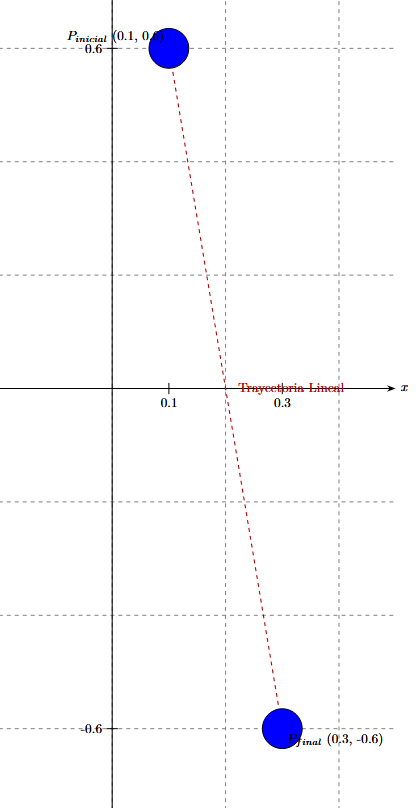

Figura 2. Esta imagen explica visualmente el objetivo de la interpolación lineal. Muestra que el robot no se mueve "articulación por articulación", sino que su efector final sigue esa línea recta.

#### Celda 3: Función de Cinemática Inversa `invk_sol`

Esta es la parte "matemágica". Esta función **no** pertenece a la clase, es una función auxiliar. Resuelve el problema de "si quiero mi mano en (x, y, $\theta$), ¿qué ángulos deben tener mis articulaciones?".

In [ ]:
def invk_sol(param, x_in, y_in, theta_in, x_fin, y_fin, theta_fin):
    Tiempo_ejec_ = 10
    # Parámetros físicos del robot (longitud de eslabones)
    L_1 = 0.5
    L_2 = 0.5
    L_3 = 0.3
    
    # --- 1. Interpolación Lineal (Espacio de la Tarea) ---
    # Esta es la ecuación de una línea recta: P(t) = P_inicial + t * (P_final - P_inicial)
    # Aquí, 't' es (param / Tiempo_ejec_)
    x_P = x_in + (param/Tiempo_ejec_)*(x_fin - x_in)
    y_P = y_in + (param/Tiempo_ejec_)*(y_fin - y_in)
    theta_P = theta_in + (param/Tiempo_ejec_)*(theta_fin - theta_in)
    
    # --- 2. Cinemática Inversa (Geométrica) ---
    
    # Primero, calculamos dónde debe estar la "muñeca" (la articulación 3, (x_3, y_3))
    # Restamos la contribución del último eslabón (L_3)
    x_3 = x_P - L_3*cos(theta_P)
    y_3 = y_P - L_3*sin(theta_P)
    
    # Ahora, resolvemos el robot RR (L_1, L_2) para el punto (x_3, y_3)
    # Usamos la Ley de Cosenos para encontrar theta_2 (ángulo del codo)
    theta_2 = acos((pow(x_3, 2)+pow(y_3,2)-pow(L_1, 2)-pow(L_2, 2))/(2*L_1*L_2))
    
    # Usamos geometría (atan2 y Ley de Cosenos) para encontrar theta_1 (ángulo de la base)
    beta = atan2(y_3, x_3)
    psi = acos((pow(x_3, 2)+pow(y_3,2)+pow(L_1, 2)-pow(L_2, 2))/(2*L_1*sqrt(pow(x_3, 2)+pow(y_3,2))))
    theta_1 = beta - psi
    
    # Finalmente, calculamos theta_3 (rotación de la muñeca)
    theta_3 = theta_P -theta_1 -theta_2
    
    # Devolvemos los ángulos en el orden correcto
    return [float(theta_1), float(theta_2), float(theta_3)]

**Explicación de `invk_sol`:**

Esta función hace dos trabajos:

1.  **Interpolación Lineal:**
    * `param` es el paso actual (nuestro `self.lamda_`). `Tiempo_ejec_` es el total de pasos.
    * La fórmula `x_P = x_in + (paso_actual / total_pasos) * (x_final - x_inicial)` es la **ecuación de una línea recta**.
    * Si `param` es 0, `x_P` será `x_in`.
    * Si `param` es 10, `x_P` será `x_fin`.
    * Si `param` es 5, `x_P` estará justo a la mitad del camino.
    * Esto garantiza que el punto `(x_P, y_P, theta_P)` se mueva en una línea recta perfecta en el espacio cartesiano.

2.  **Cinemática Inversa Geométrica (para un robot RRR planar):**
    * Una vez que tenemos el punto `(x_P, y_P, theta_P)` deseado, calculamos los ángulos.
    * El truco es "desacoplar" el problema: primero encontramos dónde debe estar la muñeca (articulación 3) y luego resolvemos el brazo de 2 eslabones (`L_1`, `L_2`).
    * `theta_2` (codo) se encuentra con la **Ley de Cosenos** sobre el triángulo formado por `L_1`, `L_2` y la distancia al punto (`x_3`, `y_3`).
    * `theta_1` (base) se encuentra usando `atan2` y otra aplicación de la **Ley de Cosenos**.
    * `theta_3` (muñeca) se calcula al final para que la orientación total sea la deseada.

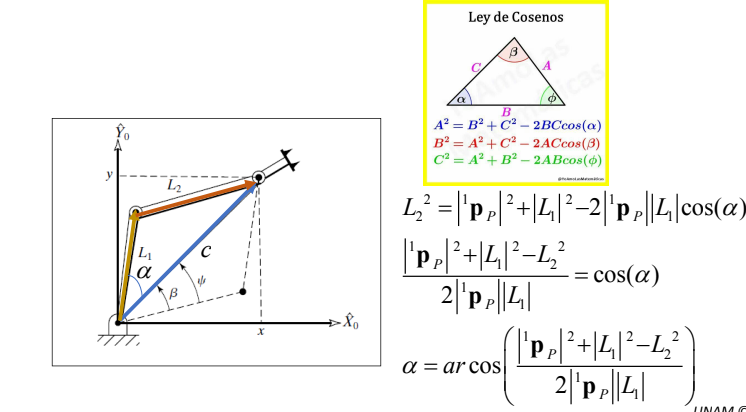

Figura 3. Diagrama que hace que las ecuaciones acos(...) y atan2(...) tengan sentido visual inmediato. Muestra exactamente qué triángulos y ángulos está resolviendo el código.

#### Celda 4: Función Principal `main`

Esta es la sección estándar que "enciende" el nodo de ROS 2.

In [ ]:
def main(args=None):
    rclpy.init(args=args)    # 1. Inicializa ROS 2
    node = ScaraTrayLineNode() # 2. Crea una instancia de nuestro nodo
    rclpy.spin(node)         # 3. Mantiene el nodo "vivo" (para que los timers y callbacks funcionen)
    rclpy.shutdown()        # 4. Apaga ROS 2 limpiamente (cuando cerramos el nodo)

if __name__ == "__main__":
    main()

## Archivo 2: `dofbot_sequence_py.py`

### 1. Resumen General

Este nodo controla un brazo robótico "Dofbot" de 5 grados de libertad (DOF) y su gripper. A diferencia del script anterior, este no genera una trayectoria *suave*, sino que ejecuta una **secuencia de posturas predefinidas**.

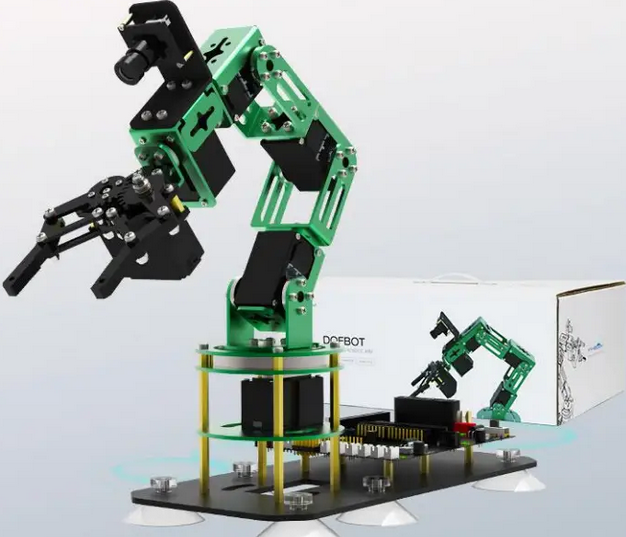

 Figura 4 . Brazo robótico "Dofbot" de 5 grados de libertad (DOF) y su gripper.



Es una **Máquina de Estados (State Machine)** muy simple. Usa una variable (`self.lamda_`) para saber "en qué paso de la secuencia estoy".

La secuencia es una tarea clásica de **Pick and Place**:
1.  Prueba el gripper (abre, cierra, abre).
2.  Moverse a la postura 1 (encima del objeto).
3.  Cerrar gripper (agarrar el objeto).
4.  Moverse a la postura 2 (levantar el objeto).
5.  Moverse a la postura 3 (moverse al lugar de entrega).
6.  Moverse a la postura 4 (bajar el objeto).
7.  Abrir gripper (soltar el objeto).
8.  Moverse a la postura "Home" (0,0,0,0,0).

Los tres ángulos que describen la orientación de un robot en el espacio. Pitch (cabeceo) es la inclinación hacia arriba o hacia abajo, yaw (guiñada) es la rotación alrededor del eje vertical y roll (alabeo) es la inclinación de lado a lado. Juntos, definen la orientación del robot con respecto a un sistema de referencia


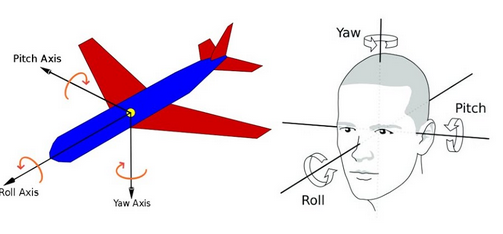

Figura 5. Diagrama donde se muestra las orientaciones de un robot en el espacio.


Para cada postura del brazo, el script define una **posición Cartesiana (x, y, z, pitch, yaw)**, usa una función de **cinemática inversa (`dofbot_ink`)** para convertila a ángulos de articulación, y la publica.


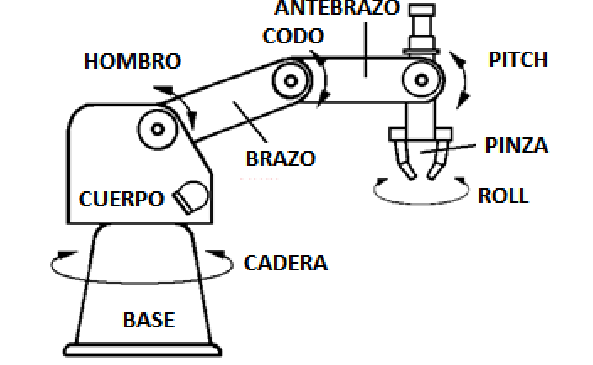

Figura 6. Diagrama simple del brazo Dofbot, mostrando sus 5 articulaciones (base, hombro, codo, pitch de muñeca, rotación de muñeca).




### 2. Análisis del Código (Celda por Celda)

#### Celda 1: Importaciones

Las importaciones son idénticas al script anterior. Usamos la misma lógica de `JointTrajectory` para comunicarnos con los controladores del robot.

In [ ]:
#!/usr/bin/env python3

import rclpy
from rclpy.node import Node
from trajectory_msgs.msg import JointTrajectory, JointTrajectoryPoint
from builtin_interfaces.msg import Duration

import time
from math import cos, sin, acos, asin, atan2, sqrt

#### Celda 2: La Clase del Nodo `DofbotControlNode`

Este nodo es más complejo porque maneja dos controladores a la vez: el del brazo y el del gripper.

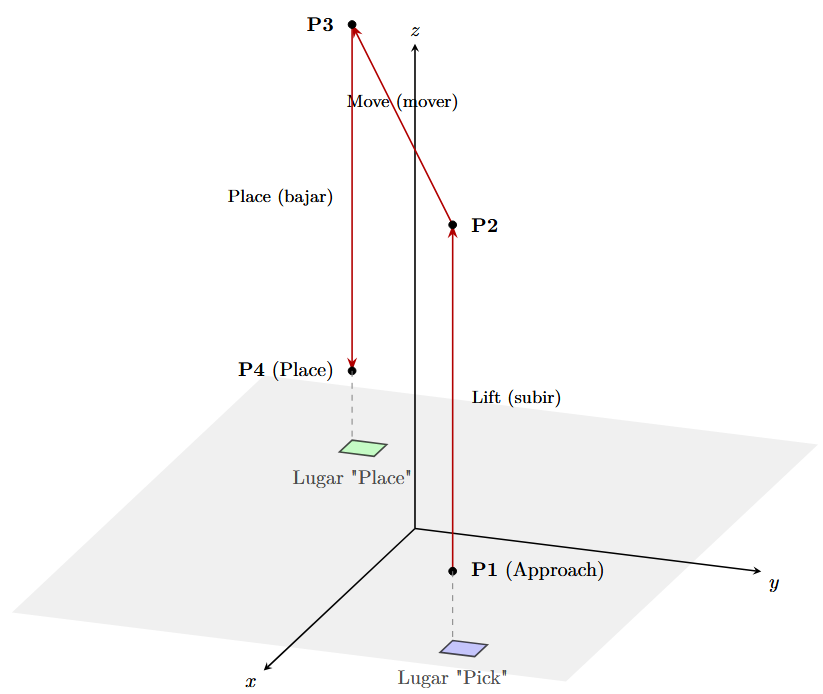




In [ ]:
class DofbotControlNode(Node):
    def __init__(self):
        super().__init__("dofbot_tray_control_node")
        self.lamda_ = 0  # Esta variable actúa como el "ESTADO" actual
        
        # --- Tópico y Publicador para el BRAZO ---
        topic_dofbot_ = "/dofbot_trajectory_controller/joint_trajectory"
        self.dofbot_publisher_ = self.create_publisher(
            JointTrajectory, topic_dofbot_, 10)
        self.dofbot_joints_ = ['arm_joint_01', 'arm_joint_02',
                                'arm_joint_03', 'arm_joint_04', 'arm_joint_05']
        
        # --- Tópico y Publicador para el GRIPPER ---
        topic_gripper_ = "/dofbot_gripper_controller/joint_trajectory"
        self.gripper_publisher_ = self.create_publisher(
            JointTrajectory, topic_gripper_, 10)
        self.gripper_joints_ = ['grip_joint', 'rfinger_joint_01',
                                 'rfinger_joint_02', 'lfinger_grip_joint_01',
                                 'lfinger_grip_joint_02', 'lfinger_grip_joint_03']
        
        # El timer comprueba el estado actual
        self.timer_ = self.create_timer(0.5, self.timer_callback) # Comprueba 2 veces por segundo
        self.get_logger().info('Nodo de control del dofbot en funcionamiento')

    def timer_callback(self):
        # Preparamos mensajes para AMBOS controladores
        dofbot_msg = JointTrajectory()
        dofbot_msg.joint_names = self.dofbot_joints_
        dofbot_point = JointTrajectoryPoint()

        gripper_msg = JointTrajectory()
        gripper_msg.joint_names = self.gripper_joints_
        gripper_point = JointTrajectoryPoint()

        # --- INICIO DE LA MÁQUINA DE ESTADOS ---
        
        if self.lamda_ == 0:
            # ESTADO 0: Abrir gripper
            self.get_logger().info('ESTADO 0: Abriendo gripper')
            gripper_st = gripper_state(1.57) # 1.57 radianes = abierto
            gripper_point.positions = gripper_st
            gripper_point._time_from_start = Duration(sec=1)
            gripper_msg.points.append(gripper_point)
            self.gripper_publisher_.publish(gripper_msg)
            time.sleep(5)  # Pausa para que la acción se complete
            self.lamda_ +=1 # Avanza al ESTADO 1

        elif self.lamda_ == 1:
            # ESTADO 1: Cerrar gripper
            self.get_logger().info('ESTADO 1: Cerrando gripper')
            gripper_st = gripper_state(0.0) # 0 radianes = cerrado
            gripper_point.positions = gripper_st
            gripper_point._time_from_start = Duration(sec=1)
            gripper_msg.points.append(gripper_point)
            self.gripper_publisher_.publish(gripper_msg)
            time.sleep(5)
            self.lamda_ +=1 # Avanza al ESTADO 2

        elif self.lamda_ == 2:
            # ESTADO 2: Abrir gripper (listo para agarrar)
            self.get_logger().info('ESTADO 2: Abriendo gripper (para pick)')
            gripper_st = gripper_state(1.57)
            gripper_point.positions = gripper_st
            gripper_point._time_from_start = Duration(sec=1)
            gripper_msg.points.append(gripper_point)
            self.gripper_publisher_.publish(gripper_msg)
            time.sleep(5)
            self.lamda_ +=1 # Avanza al ESTADO 3

        elif self.lamda_ == 3:
            # ESTADO 3: Mover a Postura 1 (Encima del objeto)
            self.get_logger().info('ESTADO 3: Moviendo a postura 1 (approach)')
            x_1 = 0.2
            y_1 = 0.0
            z_1 = 0.05
            theta_p_1 = 3.1416*(3/4) # Ángulo de Pitch (inclinación)
            theta_g_1 = 0.0          # Ángulo del Gripper (rotación)
            
            solution_pos = dofbot_ink(x_1, y_1, z_1, theta_p_1, theta_g_1)
            
            dofbot_point.positions = solution_pos
            dofbot_point.time_from_start = Duration(sec=2)
            dofbot_msg.points.append(dofbot_point)
            self.dofbot_publisher_.publish(dofbot_msg) # Publica al BRAZO
            
            self.get_logger().info('Postura 1: {}'.format(solution_pos))
            time.sleep(15) # Pausa larga para que el brazo llegue
            self.lamda_ += 1 # Avanza al ESTADO 4

        elif self.lamda_ == 4:
            # ESTADO 4: Cerrar gripper (Agarrar objeto)
            self.get_logger().info('ESTADO 4: Cerrando gripper (grasp)')
            gripper_st = gripper_state(0.0)
            gripper_point.positions = gripper_st
            gripper_point._time_from_start = Duration(sec=2)
            gripper_msg.points.append(gripper_point)
            self.gripper_publisher_.publish(gripper_msg)
            time.sleep(10)
            self.lamda_ +=1 # Avanza al ESTADO 5

        elif self.lamda_ == 5:
            # ESTADO 5: Mover a Postura 2 (Levantar objeto)
            self.get_logger().info('ESTADO 5: Moviendo a postura 2 (lift)')
            x_2 = 0.15
            y_2 = 0.0
            z_2 = 0.11
            theta_p_2 = 3.1416*(3/4)
            theta_g_2 = 0.0
            solution_pos = dofbot_ink(x_2, y_2, z_2, theta_p_2, theta_g_2)
            dofbot_point.positions = solution_pos
            dofbot_point.time_from_start = Duration(sec=2)
            dofbot_msg.points.append(dofbot_point)
            self.dofbot_publisher_.publish(dofbot_msg)
            self.get_logger().info('Postura 2: {}'.format(solution_pos))
            time.sleep(15)
            self.lamda_ += 1

        elif self.lamda_ == 6:
            # ESTADO 6: Mover a Postura 3 (Lugar de entrega)
            self.get_logger().info('ESTADO 6: Moviendo a postura 3 (move to place)')
            x_3 = 0.15
            y_3 = 0.15
            z_3 = 0.11
            theta_p_3 = 3.1416*(3/4) 
            theta_g_3 = 0.0
            solution_pos = dofbot_ink(x_3, y_3, z_3, theta_p_3, theta_g_3)
            dofbot_point.positions = solution_pos
            dofbot_point.time_from_start = Duration(sec=2)
            dofbot_msg.points.append(dofbot_point)
            self.dofbot_publisher_.publish(dofbot_msg)
            self.get_logger().info('Postura 3: {}'.format(solution_pos))
            time.sleep(15)
            self.lamda_ += 1

        elif self.lamda_ == 7:
            # ESTADO 7: Mover a Postura 4 (Bajar objeto)
            self.get_logger().info('ESTADO 7: Moviendo a postura 4 (lower)')
            x_3 = 0.15
            y_3 = 0.15
            z_3 = 0.05
            theta_p_3 = 3.1416*(3/4) 
            theta_g_3 = 0.0
            solution_pos = dofbot_ink(x_3, y_3, z_3, theta_p_3, theta_g_3)
            dofbot_point.positions = solution_pos
            dofbot_point.time_from_start = Duration(sec=2)
            dofbot_msg.points.append(dofbot_point)
            self.dofbot_publisher_.publish(dofbot_msg)
            self.get_logger().info('Postura 4: {}'.format(solution_pos))
            time.sleep(15)
            self.lamda_ += 1

        elif self.lamda_ == 8:
            # ESTADO 8: Abrir gripper (Soltar objeto)
            self.get_logger().info('ESTADO 8: Abriendo gripper (release)')
            gripper_st = gripper_state(1.57)
            gripper_point.positions = gripper_st
            gripper_point._time_from_start = Duration(sec=2)
            gripper_msg.points.append(gripper_point)
            self.gripper_publisher_.publish(gripper_msg)
            time.sleep(10)
            self.lamda_ +=1

        elif self.lamda_ == 9:
            # ESTADO 9: Mover a "HOME"
            self.get_logger().info('ESTADO 9: Moviendo a HOME')
            solution_pos = [ float(0.0), float(0.0), float(0.0), float(0.0), float(0.0)]
            dofbot_point.positions = solution_pos
            dofbot_point.time_from_start = Duration(sec=2)
            dofbot_msg.points.append(dofbot_point)
            self.dofbot_publisher_.publish(dofbot_msg)
            self.get_logger().info('Postura HOME: {}'.format(solution_pos))
            time.sleep(10)
            # ¡OJO! No hay lamda_ += 1
            # La máquina de estados se detiene aquí, en el estado 9.

**Explicación de la Clase:**

* **`__init__(self)` (El Constructor):**
    * `self.lamda_ = 0`: ¡Esta es la variable clave! Aquí **no es un parámetro de interpolación**, es un **CONTADOR DE ESTADO**. `lamda_ = 0` es el estado 0, `lamda_ = 1` es el estado 1, etc.
    * **Dos Publicadores**: Este nodo tiene dos publicadores porque controla dos `ros2_control` *controllers* diferentes:
        1.  `dofbot_publisher_`: Para el brazo (5 articulaciones).
        2.  `gripper_publisher_`: Para el gripper (6 articulaciones).
    * **Dos Listas de Joints**: Una para el brazo (`dofbot_joints_`) y otra para el gripper (`gripper_joints_`).
    * `self.timer_`: El timer llama al `timer_callback` cada 0.5 segundos para comprobar en qué estado (`lamda_`) estamos.
    * **Importante**: La temporización real de la secuencia no la da este timer, sino las pausas `time.sleep()`. Esto **bloquea el nodo** y no es una buena práctica en ROS (impediría que otros callbacks se ejecuten), pero es muy simple de leer y entender para una secuencia lineal.

* **`timer_callback(self)` (La Máquina de Estados):**
    * El código es una cadena larga de `if/elif` que comprueba el valor de `self.lamda_`.
    * Cada bloque `elif self.lamda_ == N:` corresponde a un **estado** de la secuencia.
    * Dentro de cada estado, realiza una acción:
        * O publica al `gripper_publisher_` (para abrir/cerrar).
        * O publica al `dofbot_publisher_` (para mover el brazo).
    * Para mover el brazo, define una **pose Cartesiana** (x, y, z, ...), la convierte a **ángulos de articulación** usando `dofbot_ink`, y la publica.
    * Usa `time.sleep()` para dar tiempo a que la acción se complete.
    * Al final de cada estado (excepto el último), incrementa `self.lamda_ += 1` para pasar al siguiente estado en el próximo ciclo del timer.

  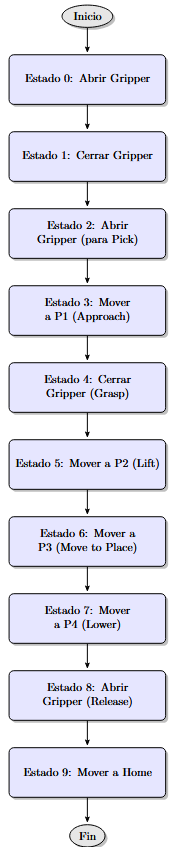


Figura 7. Diagrama de flujo (un diagrama de estados) que muestre la secuencia del roboto DOFBOT.



#### Celda 3: Funciones Auxiliares (Cinemática y Gripper)

Estas funciones calculan los ángulos necesarios para el brazo y el gripper.

In [ ]:
def dofbot_ink(x_P, y_P, z_P, theta_1_P, theta_g):
    # Parametros (longitudes) del robot Dofbot
    z_0_1 = 0.105 # Altura de la base al primer motor
    L_1 = 0.084   # Longitud eslabón 1
    L_2 = 0.084   # Longitud eslabón 2
    L_3 = 0.115   # Longitud eslabón 3 (de la muñeca al centro del gripper)

    # --- 1. Calcular Theta 1 (Base) ---
    # Es el ángulo en el plano XY (vista desde arriba)
    theta_1 = atan2(y_P, x_P)
    
    # --- 2. Calcular el centro de la muñeca (x, z en el plano 2D del brazo) ---
    # Proyectamos (x_P, y_P) en el plano del brazo
    aux_x = sqrt(pow(x_P, 2) + pow(y_P, 2)) - L_3*sin(theta_1_P)
    # Restamos la altura de la base y la de la muñeca
    aux_z = z_P - z_0_1 -L_3*cos(theta_1_P)
    
    # --- 3. Resolver el robot RR (L1, L2) para ese punto (aux_x, aux_z) ---
    # Usamos Ley de Cosenos y Senos, igual que en el SCARA
    norm_4_P = sqrt(pow(aux_z, 2)+pow(aux_x, 2))
    epsilon = acos(aux_z/norm_4_P)
    alpha = acos((pow(L_1, 2)+pow(norm_4_P, 2)-pow(L_2, 2))/(2*L_1*norm_4_P))
    theta_2 = epsilon - alpha
    theta_3 = 3.1416 - asin((sin(alpha)*sqrt(pow(aux_x, 2) + pow(aux_z, 2)))/(L_2))
    
    # --- 4. Calcular los ángulos de la muñeca ---
    theta_4 = theta_1_P - theta_2 - theta_3 # Pitch
    theta_5 = theta_g                     # Rotación del gripper
    
    # --- 5. Devolver solución (con ajustes de signo) ---
    # Los signos negativos son "factores de corrección" porque el modelo
    # matemático (URDF) puede tener ejes en dirección opuesta a la
    # usada en la geometría.
    return [ float(theta_1), float(-theta_2), float(-theta_3), float(-theta_4), float(theta_5)]

def gripper_state(theta):
    # Esta función "mapea" un solo comando (theta) a las 6 articulaciones
    # del mecanismo del gripper. Es una forma de simplificar el control.
    return [float(-theta), float(theta), float(-theta), float(theta), float(-theta), float(theta)]

**Explicación de las Funciones:**

* **`dofbot_ink` (Cinemática Inversa del Brazo):**
    * Esta es una **solución geométrica** para el Dofbot (que es un brazo de 5 DOF).
    * **Paso 1**: `theta_1` (la rotación de la base) se calcula fácil. Es solo el ángulo `atan2` de la coordenada (x, y) vista desde arriba.
    * **Paso 2**: El robot "resta" la muñeca (`L_3`) de la pose final para saber dónde tiene que estar el codo (`aux_x`, `aux_z`).
    * **Paso 3**: Resuelve la cinemática inversa para un brazo de 2 eslabones (`L_1`, `L_2`) usando **Ley de Cosenos y Ley de Senos** para encontrar `theta_2` y `theta_3`.
    * **Paso 4**: Calcula `theta_4` (pitch de la muñeca) y `theta_5` (rotación del gripper).
    * **Paso 5**: Devuelve los ángulos. Los **signos negativos** (`-theta_2`, `-theta_3`, `-theta_4`) son muy comunes. Son "factores de corrección" porque la dirección "positiva" de los ejes en el modelo URDF es opuesta a la dirección "positiva" usada en la derivación geométrica.

* **`gripper_state` (Control del Gripper):**
    * Esta es una función de "mapeo".
    * Toma **un solo** valor de entrada, `theta` (que es 0 para "cerrado" y 1.57 para "abierto").
    * Devuelve una **lista de 6 valores**. Esto es porque el gripper es un mecanismo. Las 6 articulaciones del gripper no se controlan independientemente. Mover la articulación principal (`grip_joint`) mueve todas las demás. Esta función simplifica enormemente el control del gripper.

#### Celda 4: Función Principal `main`

Finalmente, el código que inicia todo.

In [ ]:
def main(args=None):
    rclpy.init(args=args)
    node = DofbotControlNode() # Crea nuestra máquina de estados
    rclpy.spin(node)           # La mantiene viva
    rclpy.shutdown()

if __name__ == "__main__":
    main()

## Conclusiones

Del análisis de los dos nodos de ROS 2 se pueden extraer las siguientes conclusiones:

1.  **Abstracción del Control:** Ambos *scripts* demuestran el paradigma de control estándar en ROS 2 mediante el uso de `ros2_control` y el tópico `joint_trajectory`. El programador no se encarga del control de bajo nivel (como el PID de cada motor), sino que define un **plan** o **meta** (un mensaje `trajectory_msgs/JointTrajectory`) que el robot debe ejecutar.

2.  **Planeación en el Espacio de la Tarea vs. Espacio Articular:**
    * El nodo `scara_tray_line_py.py` es un claro ejemplo de **planeación de movimientos en el espacio de trabajo**. Genera una trayectoria cartesiana (una línea recta) mediante **interpolación lineal** y utiliza la **cinemática inversa** (`invk_sol`) en cada paso para encontrar la postura articular (`q`) correspondiente.
    * El nodo `dofbot_sequence_py.py` ejemplifica la **ejecución de tareas secuenciales** (una máquina de estados simple). Define un conjunto de poses cartesianas clave (acercar, agarrar, levantar, soltar) y utiliza la **cinemática inversa** (`dofbot_ink`) para calcular las posturas articulares necesarias para alcanzar dichos puntos.

3.  **Implementación de Cinemática Inversa:** Los dos archivos implementan soluciones de **cinemática inversa de la posición** de forma **geométrica**. Utilizan relaciones trigonométricas, como la ley de cosenos y la función `atan2`, para resolver la posición de los eslabones y encontrar los ángulos de las articulaciones (`theta_1`, `theta_2`, etc.) que satisfacen una pose deseada del efector final.

4.  **Control de Múltiples Componentes:** El nodo del Dofbot demuestra cómo un solo nodo de ROS 2 puede gestionar múltiples controladores (`ros2_control`) de forma simultánea (el brazo y el *gripper*), publicando en sus respectivos tópicos `joint_trajectory` para coordinar una tarea compleja como el "pick and place".




**Referencias**

[1] M. I. E. P. Medina, "scara_tray_line_py.py" y "dofbot_sequence_py.py." [Software]. Repositorio tsr-2025-2. Accedido: 22 de octubre de 2025. [En línea]. Disponible en: https://github.com/arrg-mx/tsr-2025-2/tree/main/nodos_topicos_py/nodos_topicos_py